# Semisupervised learning on MNIST

The challenge for this project was to achieve good performance in a semi-supervised learning task on the MNIST dataset. Of the 50,000 training examples, labels are available for some small subset of 100 to 500. I predominantly focused on applying a label propagation algorithm. Below I discuss why, and how it fared.

# Choice of supervised learning approach

On review of the literature, some supervised learning approaches that featured prominently were:
* Generative models:  (1) (2)
* Semi-supervised support vector machines (1)
* Self-training (2)
* Cotraining and multiview models (1) (2)
* Graph-based models (1) (2)

In order to select one of these, my main criteria were that I wanted an algorithm with an efficient runtime that would achieve good performance with few labelled examples but very many unlablled ones. Since self-training, co-training and multiview models would usually require running classifiers over the data many times, I ruled them out. Since the label propagation approach of [Zhu and Ghahramani](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.14.3864&rep=rep1&type=pdf) (3) has already demonstrated good performance on a digits dataset, I chose to apply it to MNIST.

The algorithm used was an adapted version of the algorithm used by Zhu and Ghahramani. Since the MNIST dataset is fivefold larger than the dataset used in the original paper, it was necessary to adapt the algorithm so that it does not utilize squared distances between all datapoints. Instead, a sparse kernel was used, storing just the nearest neighbours of each datapoint.

# Results

The main algorithm that was tried was label propagation. Its source of the LabelPropagation class in ../models/label_propagation.py and using five-fold cross validation, its results are demonstrated below.

In [1]:
from __future__ import division, print_function
%run '../models/label_propagation.py'
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
import json

# get model
mnist_dir = '../dat'          #the directory of mnist.ubyte files
dat = read_data_sets(mnist_dir)
train_sizes = [100, 300, 500]
k_folds = 5

sup_scores = np.zeros((len(train_sizes), k_folds)) # scores from using supervised knn only
ssl_scores = np.zeros((len(train_sizes), k_folds)) # scores from using knn on propagated labels

for fold in range(k_folds):
    for j, labelled_examples in enumerate(train_sizes):
        print('fold: {}'.format(fold), end=' ')
        i_tr, i_unlabelled = random_sample(dat.train.labels.shape[0], labelled_examples, 3000)
                
        Xtr = dat.train.images[i_tr]
        ytr = dat.train.labels[i_tr]
        ytr_onehot = np.eye(10)[ytr]
        Xunl = dat.train.images[i_unlabelled]
        Xval = dat.validation.images
        yval = dat.validation.labels

        lp = LabelPropagation(n_nearest_neighbours=10, iters=20, verbose = True) #detail of this class is in ../models/label_propgation.py
        pred = lp.propagate(Xtr, ytr_onehot, Xunl)
        
        knn = KNeighborsClassifier()

        knn.fit(np.vstack((Xtr,Xunl)), np.hstack((ytr, pred)))
        ssl_scores[j, fold] = knn.score(Xval, yval)

        knn.fit(Xtr, ytr)
        sup_scores[j, fold] = knn.score(Xval, yval)

Extracting ../dat/train-images-idx3-ubyte.gz
Extracting ../dat/train-labels-idx1-ubyte.gz
Extracting ../dat/t10k-images-idx3-ubyte.gz
Extracting ../dat/t10k-labels-idx1-ubyte.gz
fold: 0 filling neighbour row 1 / 3100
500 1000 1500 2000 2500 3000 fold: 0 filling neighbour row 1 / 3300
500 1000 1500 2000 2500 3000 fold: 0 filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 fold: 1 filling neighbour row 1 / 3100
500 1000 1500 2000 2500 3000 fold: 1 filling neighbour row 1 / 3300
500 1000 1500 2000 2500 3000 fold: 1 filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 fold: 2 filling neighbour row 1 / 3100
500 1000 1500 2000 2500 3000 fold: 2 filling neighbour row 1 / 3300
500 1000 1500 2000 2500 3000 fold: 2 filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 fold: 3 filling neighbour row 1 / 3100
500 1000 1500 2000 2500 3000 fold: 3 filling neighbour row 1 / 3300
500 1000 1500 2000 2500 3000 fold: 3 filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 fold: 

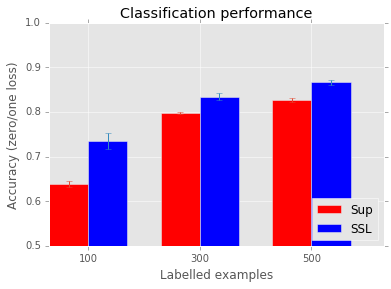

In [2]:
%run '../models/label_propagation.py'
plot_supervised_learner_performance(sup_scores, ssl_scores, title = 'Classification performance', xlab = 'Labelled examples', 
                                    ylab = 'Accuracy (zero/one loss)', ticklabs = [100,300,500], legend =['Sup', 'SSL'], ylim=(.5, 1))

Can we achieve better performance by optimizing the semisupervised learning scheme? To begin with, let us try a range of random plausible values for the number of nearby neighbours and for the number of iterations of label propagation used. Let us perform a random search (4) through two hyperparameters: nearby neighbours and iterations.

In [3]:
i_tr, i_unlabelled = random_sample(dat.train.labels.shape[0], labelled_examples, 3000)
Xtr = dat.train.images[i_tr]
ytr = dat.train.labels[i_tr]
ytr_onehot = np.eye(10)[ytr]
Xunl = dat.train.images[i_unlabelled]
Xval = dat.validation.images
yval = dat.validation.labels

In [4]:
n_settings = 8

n_neighbours_arr = np.random.random_integers(low=3, high=20, size=n_settings)
iters_arr = np.random.random_integers(low=3, high=15, size = n_settings)

In [5]:
knn = KNeighborsClassifier()
knn.fit(Xtr, ytr)
sup_score = knn.score(Xval, yval)

print('The supervised learning score was: {}'.format(sup_score))

The supervised learning score was: 0.8224


In [6]:
ssl_scores = np.zeros((n_settings,))

for i, (nn, iters) in enumerate(zip(n_neighbours_arr, iters_arr)):
    lp = LabelPropagation(n_nearest_neighbours=nn, iters=iters, verbose = True)
    yprop = lp.propagate(Xtr, np.eye(10)[ytr], Xunl)
    
    knn = KNeighborsClassifier()

    knn.fit(np.vstack((Xtr,Xunl)), np.hstack((ytr, yprop)))
    ssl_scores[i] = knn.score(Xval, yval)
    
    # find how popular each propagated class is:
    class_frequencies = {i:float("%.2f" % (i==yprop).mean()) for i in set(yprop)}
    print('iterations: {}, nearest neighbours: {}, accuracy {}, class balance: {}'.format(
            iters, nn, ssl_scores[i], class_frequencies))
best = ssl_scores.argmax()
print('the best score of {} occurred with {} nearby neighbours and {} iterations'.format(
        ssl_scores.max(), n_neighbours_arr[best], iters_arr[best]))

filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 iterations: 12, nearest neighbours: 20, accuracy 0.815, class balance: {0: 0.1, 1: 0.18, 2: 0.06, 3: 0.12, 4: 0.06, 5: 0.06, 6: 0.1, 7: 0.12, 8: 0.07, 9: 0.13}
filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 iterations: 15, nearest neighbours: 13, accuracy 0.838, class balance: {0: 0.1, 1: 0.17, 2: 0.07, 3: 0.12, 4: 0.06, 5: 0.07, 6: 0.1, 7: 0.12, 8: 0.07, 9: 0.13}
filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 iterations: 13, nearest neighbours: 20, accuracy 0.812, class balance: {0: 0.1, 1: 0.18, 2: 0.06, 3: 0.12, 4: 0.06, 5: 0.06, 6: 0.1, 7: 0.12, 8: 0.07, 9: 0.13}
filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 iterations: 10, nearest neighbours: 6, accuracy 0.8736, class balance: {0: 0.1, 1: 0.15, 2: 0.08, 3: 0.11, 4: 0.07, 5: 0.08, 6: 0.1, 7: 0.11, 8: 0.08, 9: 0.13}
filling neighbour row 1 / 3500
500 1000 1500 2000 2500 3000 iterations: 3, nearest neighbours: 17, accuracy 0.8646, clas

The classes have remained least somewhat balanced regardless of the number of iterations used. So which hyperparameter values performed best?

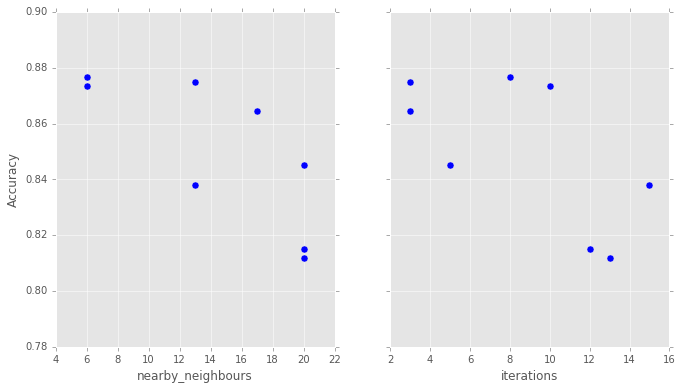

In [7]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(11, 6))

ax1.scatter(n_neighbours_arr, ssl_scores, s=50);

ax1.set_ylabel('Accuracy');
ax1.set_xlabel('nearby_neighbours');

ax2.scatter(iters_arr, ssl_scores, s=50);
ax2.set_xlabel('iterations')

Label propagation seems to work best on average with around 4-15 nearby neighbours and 3-10 iterations.

So label propagation provides a clear and significant improvement to test set classification accuracy using a K nearest neighbour classifier. But how good can our classification accuracy get using these propagated labels? To get impressive performance, we need to find the nearest neighbours across a larger portion of the dataset. This is done using stored propagated labels to save compute, though it can also be done in about an hour by uncommenting the lines from the cells below.

In [8]:
labelled_examples = 100

#random_perm = np.random.permutation(range(dat.train.labels.shape[0]))
#i_tr = random_perm[:labelled_examples]
#i_unlab = random_perm[labelled_examples:]

stored_point = json.load(open('../dat/propagated_labels.json','r'))
i_tr = np.array(stored_point['i_tr'])
i_unlab = np.array(stored_point['i_unlab'])
yprop = np.array(stored_point['yprop'])

Xtr = dat.train.images[i_tr]
ytr = np.eye(10)[dat.train.labels[i_tr]]
Xunl = dat.train.images[i_unlab]

In [ ]:
#lp = LabelPropagation(n_nearest_neighbours=10, iters=20, verbose = True)
#yprop = lp.propagate(Xtr, ytr, Xunl)
#yprop = np.eye(10)[yprop]

In [9]:
y_train =np.vstack((ytr, yprop))
x_train = np.vstack((Xtr, Xunl))
x_train = x_train.reshape(x_train.shape[0],1,28,28)

We use a standard modern convolutional neural network with 4 layers, dropout, relu activations and light weight regularization, and train this on labels that were propagated using the previous technique.

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import log_loss
from keras.regularizers import WeightRegularizer

def create_model(img_rows, img_cols,learning_rate, reg, decay, momentum=.9, dropout = .5):
    model = Sequential()
    model.add(Convolution2D(128, 5, 5, border_mode='same', init='he_normal', W_regularizer=WeightRegularizer(l1=reg),
                            input_shape=(1, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Convolution2D(312, 3, 3, border_mode='same', init='he_normal', W_regularizer=WeightRegularizer(l1=reg)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Convolution2D(172, 3, 3, border_mode='same', init='he_normal', W_regularizer=WeightRegularizer(l1=reg)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Convolution2D(172, 3, 3, border_mode='same', init='he_normal', W_regularizer=WeightRegularizer(l1=reg)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(48))
    
    model.add(Dense(10))
    model.add(Activation('softmax'))

    sgd = SGD(lr=learning_rate, decay=decay, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model

Using TensorFlow backend.


In [11]:
batch_size = 32
nb_epoch = 50
dropout = .60
reg = 1e-6
learning_rate = 1e-4
decay = 1e-5
momentum = .95
prop_weight = .2

sample_weight = np.ones((x_train.shape[0],))
sample_weight[100:] /= prop_weight

model = create_model(28, 28, learning_rate=learning_rate, reg=reg, decay = decay, dropout = dropout)

x_val = dat.validation.images
x_val = x_val.reshape(x_val.shape[0], 1, 28, 28)

model.fit(x_train, np.vstack((ytr, yprop)), batch_size=batch_size, nb_epoch=nb_epoch,
      shuffle=True, verbose=2, validation_data=(x_val, np.eye(10)[dat.validation.labels]),
      callbacks=[EarlyStopping(monitor='val_loss', patience=4, verbose=0)],
            sample_weight=sample_weight)

x_test = dat.test.images
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

predictions_test = model.predict(x_test, verbose=1)
print('Validation set accuracy: {}'.format((dat.test.labels==predictions_test.argmax(axis=1)).mean()))

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
65s - loss: 20.8670 - val_loss: 1.4048
Epoch 2/50
64s - loss: 11.3270 - val_loss: 0.9489
Epoch 3/50
64s - loss: 8.4550 - val_loss: 0.6812
Epoch 4/50
64s - loss: 7.0113 - val_loss: 0.5888
Epoch 5/50
64s - loss: 6.1942 - val_loss: 0.5387
Epoch 6/50
64s - loss: 5.7211 - val_loss: 0.5046
Epoch 7/50
64s - loss: 5.3033 - val_loss: 0.4722
Epoch 8/50
64s - loss: 5.1085 - val_loss: 0.5055
Epoch 9/50
64s - loss: 4.7926 - val_loss: 0.4617
Epoch 10/50
64s - loss: 4.6286 - val_loss: 0.4743
Epoch 11/50
64s - loss: 4.4663 - val_loss: 0.4383
Epoch 12/50
64s - loss: 4.2820 - val_loss: 0.4507
Epoch 13/50
65s - loss: 4.1994 - val_loss: 0.4283
Epoch 14/50
64s - loss: 4.1435 - val_loss: 0.4246
Epoch 15/50
64s - loss: 3.9783 - val_loss: 0.4121
Epoch 16/50
64s - loss: 3.9317 - val_loss: 0.4418
Epoch 17/50
64s - loss: 3.8893 - val_loss: 0.4655
Epoch 18/50
64s - loss: 3.7783 - val_loss: 0.4362
Epoch 19/50
64s - loss: 3.7436 - val_loss: 0.4607
Epoch 20

Of course, a neural net cannot perform anywhere near this well without the propagated labels:

In [13]:
model = create_model(28, 28, learning_rate=learning_rate, reg=reg, decay = decay, dropout = dropout)

model.fit(Xtr.reshape(100,1,28,28), ytr, batch_size=batch_size, nb_epoch=nb_epoch, shuffle=True, verbose=2, 
      validation_data=(dat.validation.images.reshape(dat.validation.images.shape[0],1,28,28), np.eye(10)[dat.validation.labels]),
      callbacks=[EarlyStopping(monitor='val_loss', patience=4, verbose=0)])

predictions_test = model.predict(x_test, verbose=1)

print('Validation set accuracy: {}'.format((dat.test.labels==predictions_test.argmax(axis=1)).mean()))

Train on 100 samples, validate on 5000 samples
Epoch 1/50
2s - loss: 13.2731 - val_loss: 2.9490
Epoch 2/50
2s - loss: 13.8733 - val_loss: 2.7319
Epoch 3/50
2s - loss: 12.3277 - val_loss: 2.7001
Epoch 4/50
2s - loss: 11.9342 - val_loss: 2.7289
Epoch 5/50
2s - loss: 12.3815 - val_loss: 3.0577
Epoch 6/50
2s - loss: 12.0577 - val_loss: 3.3511
Epoch 7/50
2s - loss: 12.6683 - val_loss: 3.6526
Epoch 8/50
2s - loss: 12.3590 - val_loss: 3.7865
10000/10000 [==============================] - 4s     
Validation set accuracy: 0.101


# Discussion

There are three main issues to remark on: 
1. Design choices for label propagation class
2. Other approaches that were tried
3. Other approaches that should be tried

## Design choices for label propagation
The main challenges in designing the label propagation class arose from limited computing time. The MNIST dataset contains 5x more examples than the original dataset of digits used by Zhu and Gharamani. So using a dense matrix to represent similarities between 55,000 datapoints in memory is barely possible, and performing further computations such as matrix multiplications on this matrix is infeasibly slow. Instead, it was necessary to augment Zhu and Gharamani's algorithm to use a sparse representation for similarity. A natural choice is to compute a kernel that lists the k nearest neighbours, and this is what was done. Using brute force, one would find neighbours by minimizing the squared distance between each pair of points, and this is what was done. An alternative algorithm for finding the minimum distance, the k-d tree was attempted. In theory, this gives a lookup speed of d x n x log(n) where 'd' is dimensionality and 'n' is the number of datapoints rather than d x n x n for the brute force approach. However, this did not give much significant speedup in practise and was in fact slower when 'n' was small. The label propagation algorithm was also parameterised with a number of iterations in order to give the user control of computing time and behaviour.

A second design choice related to ensuring balance among the propagated classes. A difficulty with this algorithm is that if one class is propagated more widely than others, then in order to match their neighbours, many unlabelled nodes will also join that class. In order to avoid a bandwagon effect, "class mass normalisation" was performed (as Zhu and Ghahramani themselves proposed) so that the sum of the columns was made to equal zero, so that roughly equal amounts of each class were predicted. The accuracy is very inconsistent if class mass normalisation is not used.

## Other approaches that were tried
The main other approach that was tried was a self-training approach. Using built-in logistic regression or support vector machines, an effort was made to apply labels to all unlabelled examples in decreasing order of certainty. In the case of logistic regression, this was only able to improve performance to a few percentage points above baseline - around 76%.

## Other approaches that appear worth trying
The main approach that appears worth exploring is to train a deep model with both supervised and unsupervised training objectives from end-to-end. (5), (6) This seems to offer state-of-the-art performance presently. In particular, ladder networks have achieved an impressive error rate of only 1.06% using only 100 labelled examples, and so their approach would be worth seeking to emulate. Another approach that has served as a benchmark for this sort of problem historically is the transductive SVM, which would also be worth testing.

# Citations

1. [Zhu, Xiaojin. "Semi-supervised learning." Encyclopedia of machine learning. Springer US, 2011. 892-897.](http://pages.cs.wisc.edu/~jerryzhu/ssl/pub/SSL_EoML.pdf)
2. [Prakash, V. Jothi, and Dr LM Nithya. "A survey on semi-supervised learning techniques." arXiv preprint arXiv:1402.4645 (2014).](http://arxiv.org/pdf/1402.4645.pdf)
3. [Zhu, Xiaojin, and Zoubin Ghahramani. Learning from labeled and unlabeled data with label propagation. Technical Report CMU-CALD-02-107, Carnegie Mellon University, 2002.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.14.3864&rep=rep1&type=pdf)
4. [Bergstra, James, and Yoshua Bengio. "Random search for hyper-parameter optimization." Journal of Machine Learning Research 13.Feb (2012): 281-305.](http://www.jmlr.org/papers/v13/bergstra12a.html)
5. [Rasmus, Antti, et al. "Semi-supervised learning with ladder networks." Advances in Neural Information Processing Systems. 2015.](http://papers.nips.cc/paper/5947-semi-supervised-learning-with-ladder-networks.pdf)
6.  [Weston, Jason, et al. "Deep learning via semi-supervised embedding." Neural Networks: Tricks of the Trade. Springer Berlin Heidelberg, 2012. 639-655.](https://infoscience.epfl.ch/record/192705/files/Weston_SPRINGER_2012.pdf)